This is the Ronneberger UNET, a segmentation model

Ronneberger et al. 2015 -- https://arxiv.org/abs/1505.04597

Use Doodler to get labels for your images: https://github.com/dbuscombe-usgs/dash_doodler


In [1]:
# import the packages we need...
#first, the general stuff
import os
from os import getcwd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.2


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#define the number of classes of the image...these are NOAA, so 

num_classes = 4

#this is a fn to make sure the labels go from 0- (num_classes-1)

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image

In [4]:
#build data flow routines, gettign the data from the files to the netowrk...

#first we decide how much of the data is training and how much is validation
split = 0.4

# Define dirs and files where the images and labels are.. Use doodler to get labels for your images!
image_dir = '../data/segmentation/images'
label_dir = '../data/segmentation/labels'

#to make it deterministic, set the seed
SEED = 11

# We will use generators to flow the data.. for both training and validaton
# We also add some weak data-augmentation, and rescale the images here.
# note that we are using the generator to split the data. 
train_image_datagen = ImageDataGenerator(rescale =1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)

train_mask_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True,
                                   preprocessing_function = D_Filter,
                                   validation_split = split )

#set batch Size for the model — how many images go into the network at each
#step. 
batch_size = 4

#set Image size. We are using the UNET directly from the paper, so image size
# is 572 x 572 (RGB so imshape is 3)
pix_dim = 572
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

#And in this implementation, the mask size is actually different (388 x 388).
# this is usually not the case 
mask_pix_dim = 388 #572
masksize = (mask_pix_dim,mask_pix_dim) 


### This is where we set the generator to flow images from the folders into the 
#training. The is a generator for the image and another for the mask. And also 
# generators for the traing and val.. so 4 total.:

train_image_generator = train_image_datagen.flow_from_directory(image_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset ='training')

train_label_generator = train_mask_datagen.flow_from_directory(label_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'training')

# we merge the two training generators (image and mask) so that it looks like a
# a single generator 
train_generator = zip(train_image_generator, train_label_generator)



# Flow validation images in batches 


val_image_generator = train_image_datagen.flow_from_directory(image_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset = 'validation')

val_label_generator = train_mask_datagen.flow_from_directory(label_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'validation')

#merge generators
validation_generator = zip(val_image_generator, val_label_generator)


Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 140 images belonging to 1 classes.
Found 140 images belonging to 1 classes.


In [5]:
#Set total number of images in each subset, which is the output from the above cell.
# this will be used later when we train the model
total_train = 210
total_val = 140

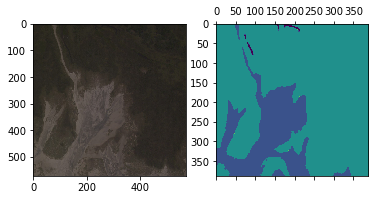

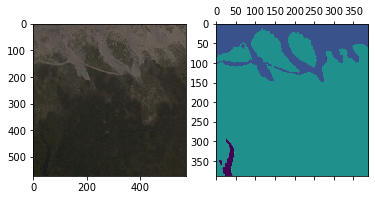

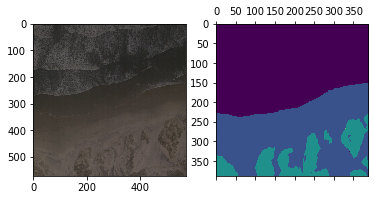

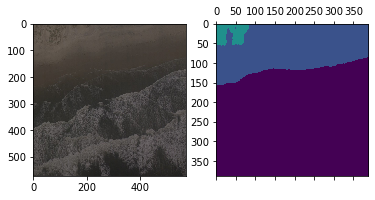

In [14]:
#as an idiot check, lets look at the output of the generator.
#for a full training batch... 

x,y = next(train_generator)

for count,(im,lab) in enumerate(zip(x, y)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(im)
    ax2.matshow(lab.squeeze(), vmin = 0, vmax = 4)


In [15]:
#the model
#first we define the inputs, which is the shape of images defined in teh code blocks above 
inputs = layers.Input(imshape)

# 'Honey I shrunk the kids"'
# now we set up 4 blocks of comvolutons in the 'encoder' part
#block1
conv1 = layers.Conv2D(64, 3, activation = 'relu', strides=(1,1))(inputs)
conv1 = layers.Conv2D(64, 3, activation = 'relu', strides=(1,1))(conv1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#block2
conv2 = layers.Conv2D(128, 3, activation = 'relu', strides=(1,1))(pool1)
conv2 = layers.Conv2D(128, 3, activation = 'relu', strides=(1,1))(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#block3
conv3 = layers.Conv2D(256, 3, activation = 'relu', strides=(1,1))(pool2)
conv3 = layers.Conv2D(256, 3, activation = 'relu', strides=(1,1))(conv3)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

#block4
conv4 = layers.Conv2D(512, 3, activation = 'relu', strides=(1,1))(pool3)
conv4 = layers.Conv2D(512, 3, activation = 'relu', strides=(1,1))(conv4)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)


# we shrink as far as we are going to go...
#bottlneck
conv5 = layers.Conv2D(1024, 3, activation = 'relu', strides=(1,1))(pool4)
conv5 = layers.Conv2D(1024, 3, activation = 'relu', strides=(1,1))(conv5)
upconv5 = layers.Conv2DTranspose(512, kernel_size=(2, 2), strides = (2,2))(conv5)

# 'Honey I blew up the kids"... we upsample now
#upblock 1
crop6 = layers.Cropping2D(cropping=(4,4))(conv4)
conc6 = layers.Concatenate(axis=3)([upconv5, crop6])
conv6 = layers.Conv2D(512, 3, activation = 'relu', strides=(1,1))(conc6)
conv6 = layers.Conv2D(512, 3, activation = 'relu', strides=(1,1))(conv6)
upconv6 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides = (2,2))(conv6)

#upblock 2
crop7 = layers.Cropping2D(cropping=(16,16))(conv3)
conc7 = layers.Concatenate(axis=3)([upconv6, crop7])
conv7 = layers.Conv2D(256, 3, activation = 'relu', strides=(1,1))(conc7)
conv7 = layers.Conv2D(256, 3, activation = 'relu', strides=(1,1))(conv7)
upconv7 = layers.Conv2DTranspose(128, kernel_size=(2, 2), strides = (2,2))(conv7)

#upblock 3
crop8 = layers.Cropping2D(cropping=(40,40))(conv2)
conc8 = layers.Concatenate(axis=3)([upconv7, crop8])
conv8 = layers.Conv2D(128, 3, activation = 'relu', strides=(1,1))(conc8)
conv8 = layers.Conv2D(128, 3, activation = 'relu', strides=(1,1))(conv8)
upconv8 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides = (2,2))(conv8)

#upblock 4
crop9 = layers.Cropping2D(cropping=(88,88))(conv1)
conc9 = layers.Concatenate(axis=3)([upconv8, crop9])
conv9 = layers.Conv2D(64, 3, activation = 'relu', strides=(1,1))(conc9)
conv9 = layers.Conv2D(64, 3, activation = 'relu', strides=(1,1))(conv9)

#we define the outputs here
outputs = layers.Conv2D(4, (1, 1), padding="same", activation="softmax")(conv9)
#outputs = layers.Conv2D(4, (1, 1), padding="same")(conv9)

#combine the model together
model = Model(inputs, outputs)

#and print out the text summary of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 572, 572, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 284, 284, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

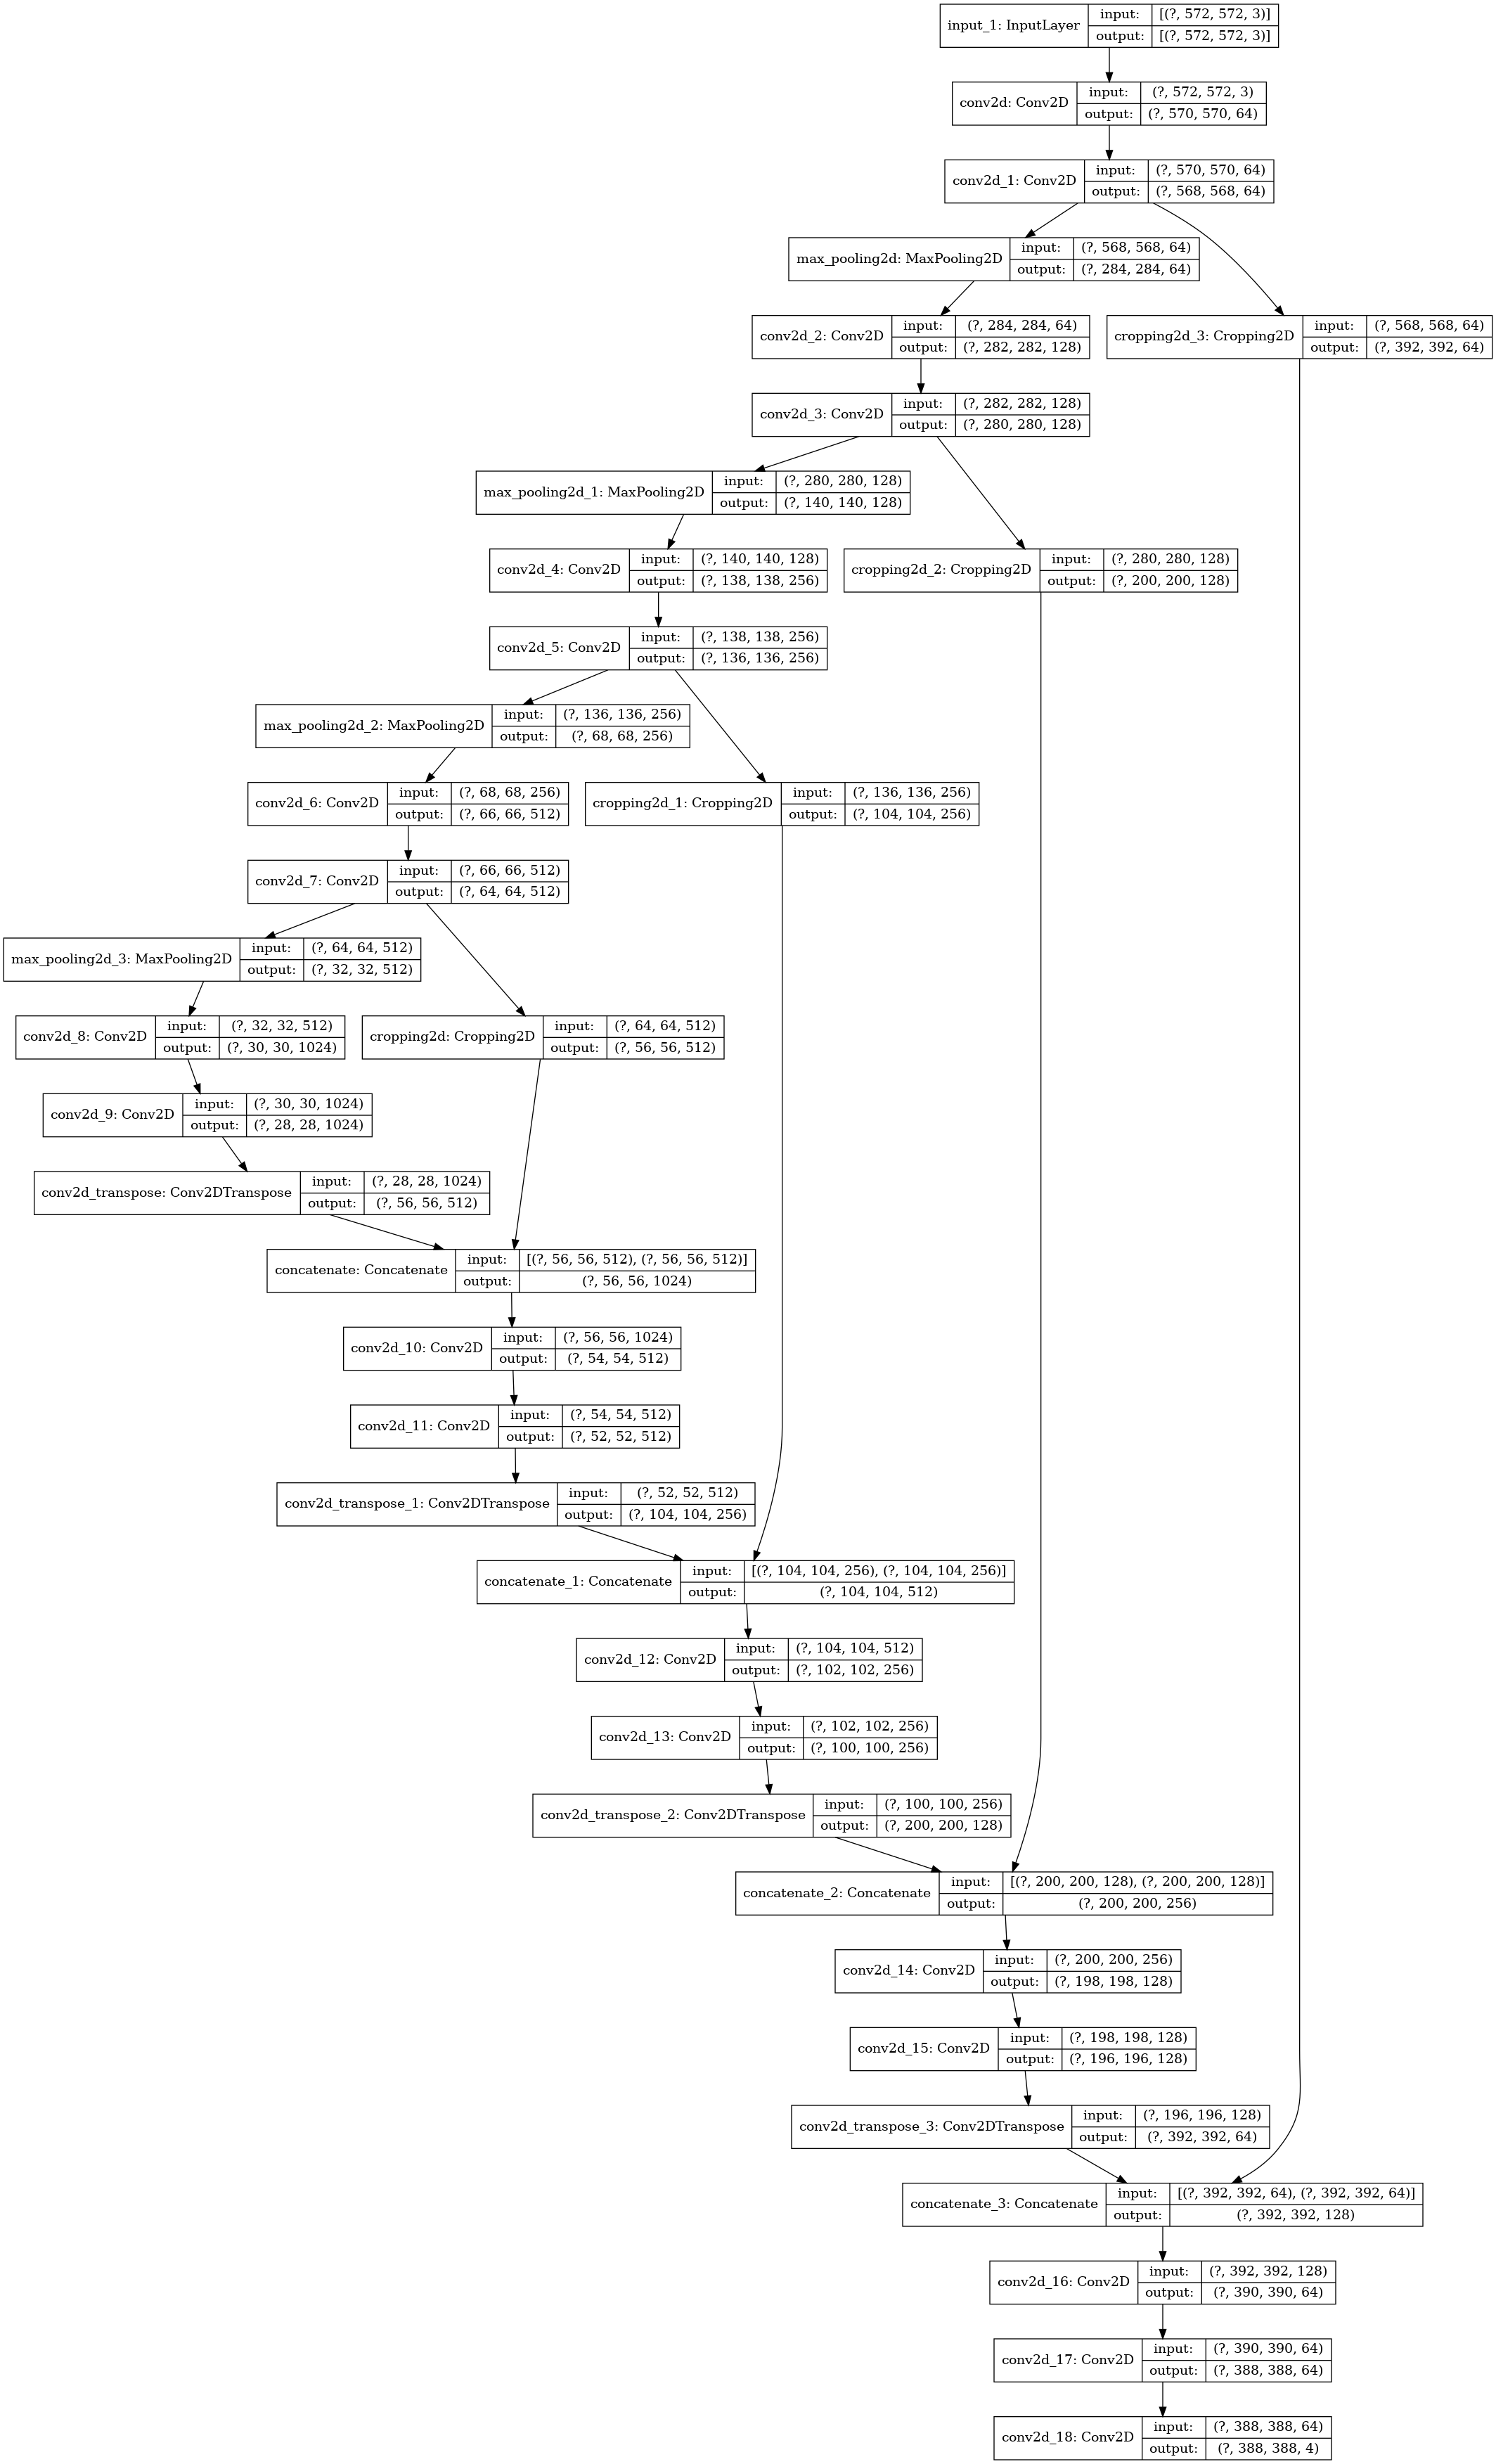

In [16]:
# here is a graphic summary of the model... you can see the downsampling, bottleneck, and upsampling, connected to each other via skip connections
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
#we compile the model, set a loss function, and also an optimizer. 

model.compile( loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam())

In [18]:
# define a callback, which runs during training and does something for us. 
#This one looks at the training loss, and stops the training if the loss does 
#not improve from some number of epochs. Then it reverts to the best version of 
# the model, where loss was lowest

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'loss', 
                                             patience = 10, 
                                             restore_best_weights = True)

In [19]:
#lets now train the model! We can store all teh model output in 'history'.
# note that we are using the training generator for training data, the val 
# generator for validation data, we set the model to train for 30 epochs, 
# we tell teh network how many steps there are to get through the entire data set
# and we also give the network our callback to use.

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 100,
                    steps_per_epoch = total_train // batch_size,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/100
52/52 [==============================] - 13s 250ms/step - loss: 1.2009 - val_loss: 1.2862
Epoch 2/100
52/52 [==============================] - 11s 215ms/step - loss: 1.2480 - val_loss: 1.2401
Epoch 3/100
52/52 [==============================] - 11s 215ms/step - loss: 1.1633 - val_loss: 1.1436
Epoch 4/100
52/52 [==============================] - 11s 212ms/step - loss: 1.1425 - val_loss: 1.2241
Epoch 5/100
52/52 [==============================] - 11s 212ms/step - loss: 1.1599 - val_loss: 1.1950
Epoch 6/100
52/52 [==============================] - 11s 213ms/step - loss: 1.1641 - val_loss: 1.1471
Epoch 7/100
52/52 [==============================] - 11s 214ms/step - loss: 1.1258 - val_loss: 1.1995
Epoch 8/100
52/52 [==============================] - 11s 214ms/step - loss: 1.1130 - val_loss: 1.1883
Epoch 9/100
52/52 [==============================] - 11s 214ms/step - loss: 1.0943 - val_loss: 1.3004
Epoch 10/100
52/52 [==============================] - 11s 215ms/step - loss: 1.115

52/52 [==============================] - 11s 216ms/step - loss: 0.8807 - val_loss: 1.2447
Epoch 79/100
52/52 [==============================] - 11s 215ms/step - loss: 0.8794 - val_loss: 1.2417
Epoch 80/100
52/52 [==============================] - 11s 216ms/step - loss: 0.8767 - val_loss: 1.2330
Epoch 81/100
52/52 [==============================] - 11s 216ms/step - loss: 0.8735 - val_loss: 1.2258
Epoch 82/100
52/52 [==============================] - 11s 216ms/step - loss: 0.8698 - val_loss: 1.2172
Epoch 83/100
52/52 [==============================] - 11s 216ms/step - loss: 0.8790 - val_loss: 1.2083
Epoch 84/100
52/52 [==============================] - 11s 215ms/step - loss: 0.8747 - val_loss: 1.2580
Epoch 85/100
52/52 [==============================] - 11s 217ms/step - loss: 0.8754 - val_loss: 1.2329
Epoch 86/100
52/52 [==============================] - 11s 218ms/step - loss: 0.8747 - val_loss: 1.2455
Epoch 87/100
52/52 [==============================] - 12s 221ms/step - loss: 0.8745 - 

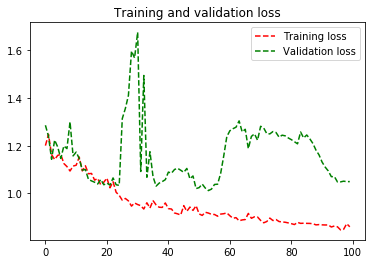

<Figure size 432x288 with 0 Axes>

In [20]:
#now that training is done, lets look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'g--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

# # if you have another metric... i.e.,accuracy
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()
# plt.show()


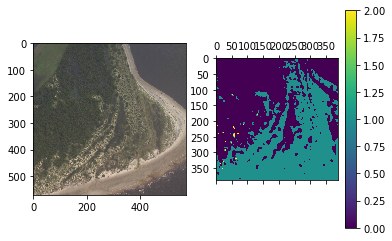

In [21]:
#lets look at the model prediction on a single image.

# here is the gdrive path to the image
imgp = '../data/segmentation/images/img/P26054317-1_EBG.jpg'

#we pull the image and preprocess it — normalizing and making it a array/tensor
img = tf.keras.preprocessing.image.load_img(imgp,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img = np.expand_dims(img,axis=0)

#We use the model to make a prediction on this image
pred = model.predict(img)

# we use argmax to get the labels for the image (recall the output of the 
# model is a tensor with shape of the image and then a depth equal to the 
# number of classes. this argmax and squeeze are here to collapse that).
lab = np.argmax(pred.squeeze(),-1)


#lets look at the model results and the image

imgUP = matplotlib.image.imread(imgp)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.squeeze())
labels = ax2.matshow(lab)
cax = fig.colorbar(labels, ax = ax2)
plt.show()

# recall that water: 0; sand:1; veg : 2; dev : 3